In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
%pip install osmnx
import osmnx as ox
%pip install h3
import h3
%pip install libpysal
import libpysal as lps

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [104]:
# we'll begin by borrowing the plotting helper function we created in the geoprocessing notebook for use here.
# oftentimes when writing functions that we want to come back to, we can create a new python file (such as utils.py)
# and import functions from there.
def set_axis_off():
    """
    Set the default matplotlib settings to turn off axes and ticks.
    This function modifies the global matplotlib configuration to hide axes and ticks
    for all plots created after this function is called.
    """
    # set axis off by default
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    # set tick params off by default
    plt.rcParams["xtick.bottom"] = False
    plt.rcParams["xtick.top"] = False
    plt.rcParams["xtick.labelbottom"] = False
    plt.rcParams["xtick.labeltop"] = False
    plt.rcParams["ytick.left"] = False
    plt.rcParams["ytick.right"] = False
    plt.rcParams["ytick.labelleft"] = False
    plt.rcParams["ytick.labelright"] = False

In [105]:
set_axis_off()

In [78]:
#bounding box of NYC 
bbox = (-74.3, 40.5, -73.7, 40.9)

# Isochrone Generation for Cooling Centers in NYC

In this project, I define New York City’s pedestrian network by combining street data with key points of interest: cooling centers and pedestrian-friendly streets. Using Mapbox’s isochrone generation tool, I calculate walking sheds (areas accessible within a given walking time) from each location.

While a Euclidean distance model might draw a perfect circle around each site, this approach instead accounts for the actual street network, including turns, intersections, and physical barriers. The result is a more realistic picture of accessibility: irregular shapes that reflect the lived experience of navigating the city on foot.

The contrast between Euclidean and network distance here is significant. A location that seems “close” in straight-line terms may require a long detour because of street patterns, blocked crossings, or limited pedestrian infrastructure. Conversely, some locations may be reachable faster than expected due to direct pedestrian corridors. Walking sheds reveal these differences visually, highlighting the complexity of urban movement and emphasizing how design decisions shape accessibility in ways that pure geometry cannot capture.




In [148]:
import geopandas as gp
import pandas as pd
from shapely.geometry import Polygon
%pip install routingpy
from routingpy.routers import MapboxOSRM
import numpy as np

mb = MapboxOSRM(api_key = "pk.eyJ1Ijoic2ZkdW5jYW4iLCJhIjoiY2x2Z3QybHh2MHlwcTJpczJyejAyYWVpNyJ9.DLToR14vGnafkx-pCGj6KA")

Note: you may need to restart the kernel to use updated packages.


In [59]:
cooling_centers = gpd.read_file("cooling_centers.geojson").to_crs("EPSG:4326")

In [60]:
cooling_centers.head()

,Status,FeatureType,PropertyName,SubPropertyName,GISPropNum,OMPPropID,Borough,District,x,y,geometry
0,Activated,Misting Station,Newtown Barge Playground,None,B135,B135,Brooklyn,B-01,-73.959783,40.735982,POINT (-77.51985 40.11249)
1,Activated,Hydrant Spray Cap,Randall's Island Park,None,M107,M107,Manhattan,M-11R,-73.934913,40.783632,POINT (-77.51985 40.11249)
2,Activated,Hydrant Spray Cap,Randall's Island Park,None,M107,M107,Manhattan,M-11R,-73.934148,40.783371,POINT (-77.51985 40.11249)
3,Activated,Misting Station,Rockaway Beach Boardwalk,None,Q163,Q163,Queens,Q-14,-73.829813,40.579326,POINT (-77.51985 40.11249)
4,Activated,Misting Station,Rockaway Beach Boardwalk,None,Q163,Q163,Queens,Q-14,-73.828585,40.579697,POINT (-77.51985 40.11249)


In [61]:
from shapely.geometry import Point
import geopandas as gpd

# Rebuild geometry with correct lon/lat
cooling_centers["geometry"] = cooling_centers.apply(
    lambda row: Point(row["x"], row["y"]),
    axis=1
)

# Ensure CRS is WGS84
cooling_centers = gpd.GeoDataFrame(cooling_centers, geometry="geometry", crs="EPSG:4326")


In [62]:
cooling_centers.explore()

In [63]:
def mb_isochrone(cooling_centers, time = [5, 10, 15], profile = "walking"):

    # Grab X and Y values in 4326
    cooling_centers['x'] = cooling_centers.to_crs(4326).geometry.x
    cooling_centers['y'] = cooling_centers.to_crs(4326).geometry.y

    coordinates = cooling_centers[['x', 'y']].values.tolist()

    # Build a list of shapes
    isochrone_shapes = []

    if type(time) is not list:
        time = [time]

    # Use minutes as input, but the API requires seconds
    time_seconds = [60 * x for x in time]

    # Given the way that routingpy works, we need to iterate through the list of 
    # coordinate pairs, then iterate through the object returned and extract the 
    # isochrone geometries.  
    for c in coordinates:
        iso_request = mb.isochrones(locations = c, profile = profile,
                                    intervals = time_seconds, polygons = "true")

        for i in iso_request:
            iso_geom = Polygon(i.geometry[0])
            isochrone_shapes.append(iso_geom)

    # Here, we re-build the dataset but with isochrone geometries
    df_values = cooling_centers.drop(columns = ['geometry', 'x', 'y'])

    time_col = time * len(df_values)

    # We'll need to repeat the dataframe to account for multiple time intervals
    df_values_rep = pd.DataFrame(np.repeat(df_values.values, len(time_seconds), axis = 0))
    df_values_rep.columns = df_values.columns

    isochrone_gdf = gp.GeoDataFrame(
        data = df_values_rep,
        geometry = isochrone_shapes,
        crs = 4326
    )

    isochrone_gdf['time'] = time_col

    # We are sorting the dataframe in descending order of time to improve visualization
    # (the smallest isochrones should go on top, which means they are plotted last)
    isochrone_gdf = isochrone_gdf.sort_values('time', ascending = False)

    return(isochrone_gdf)

In [66]:
cooling_isos = mb_isochrone(cooling_centers, time = [5, 10, 15], 
                            profile = "walking")

cooling_isos.explore(column="time", cmap="YlOrRd", legend=True)

## This is my Network Stuff 

Ultimately, it was taking way too long to generate a network dataset from the dataset above (probably because I was trying to pull streets for the entire city). Thus, I am pulling a different dataset that is much smaller!

In addition to the New York City analysis, I also calculated the street network and shortest routes in Anchorage, Alaska, between the University of Alaska Anchorage (UAA) and surrounding bus stops. 

In [ ]:
PLACE = "Anchorage, Alaska, USA"

In [84]:
# 1) Boundary
place = ox.geocode_to_gdf(PLACE)

In [85]:
# 2) Bus features
stops = ox.features_from_place(PLACE, tags={"highway": "bus_stop"})
stations = ox.features_from_place(PLACE, tags={"amenity": "bus_station"})
platforms = ox.features_from_place(PLACE, tags={"public_transport": "platform"})
platforms = platforms[platforms.get("bus").eq("yes")]  # keep bus platforms only

In [89]:
# 3) I need to reduce these to points because I believe these are polygons
def to_points(gdf):
    pts = gdf[gdf.geometry.type.isin(["Point", "MultiPoint"])].copy()
    polys = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    if len(polys):
        polys["geometry"] = polys.geometry.centroid
        pts = pd.concat([pts, polys], ignore_index=True)
    return pts

In [90]:
bus_pts = pd.concat(
    [to_points(stops), to_points(stations), to_points(platforms)],
    ignore_index=True
)

In [91]:
bus_pts = bus_pts.set_crs(4326) if bus_pts.crs is None else bus_pts.to_crs(4326)


In [76]:
# OSMnx 2.x syntax
t_network = ox.graph_from_bbox(
    bbox=(maxy, miny, maxx, minx),  # north, south, east, west
    network_type="walk"
)

In [92]:
# 4) Walking network for access analysis
G = ox.graph_from_place(
    PLACE,
    network_type="walk",
    retain_all=True,
    truncate_by_edge=True
)

In [ ]:
# 5) Snap stops to nearest network nodes
from osmnx import distance as oxdist
xs = bus_pts.geometry.x.values
ys = bus_pts.geometry.y.values
bus_pts["nearest_node"] = oxdist.nearest_nodes(G, X=xs, Y=ys)

<Axes: >

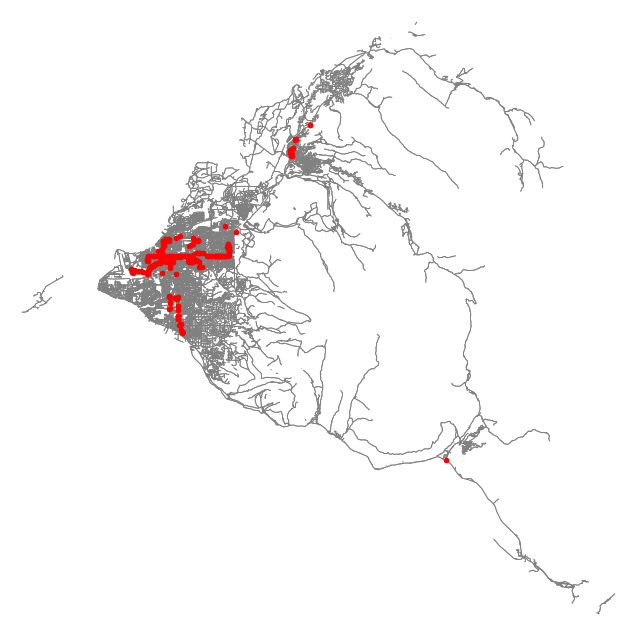

In [93]:
# Plot the network and bus stops on one map
fig, ax = ox.plot_graph(
    G,
    node_size=0,               # no node circles
    edge_color="gray",
    edge_linewidth=0.6,
    bgcolor="white",
    show=False,
    close=False
)

# Plot bus stops on top
bus_pts.plot(
    ax=ax,
    color="red",
    markersize=8,
    zorder=3
)

#### I did not like the above plot (I was trying something new that I saw on a tutorial), so I opted to using the following code instead: 

In [94]:
anchorage_busstops = gpd.read_file("Anchorage_Bus.geojson").to_crs("EPSG:4326")


In [95]:
anchorage_busstops.head()

,OBJECTID,BUSSTOPNUMBER,BUSSTOPNAME,XCOORD,YCOORD,PUBDATE,CONNECTED_ROUTES,Avg_Ridership_Boardings,Avg_Ridership_Alights,Ridership_Year,...,Shelter,Trashcan,Lighting,LeanerRail,HeatedSidewalk,ElectronicSign,HeatedWaitingArea,LastService,LastServiceDate,geometry
0,1,14,36TH AVENUE & C STREET ESE,-149.885213,61.187997,"Thu, 07 Aug 2025 09:00:00 GMT",Route 85,2.361446,4.244980,2024.0,...,No,Yes,No,Unknown,Unknown,Unknown,Unknown,None,None,POINT (-149.88524 61.188)
1,2,15,36TH AVENUE & A STREET ESE,-149.881810,61.187957,"Thu, 07 Aug 2025 09:00:00 GMT",Route 85,6.100402,9.907631,2024.0,...,Yes,Yes,Yes,Unknown,Unknown,Unknown,Unknown,Cleaned,"Wed, 30 Jul 2025 19:15:04 GMT",POINT (-149.88183 61.18796)
2,3,89,LAKE OTIS & 42ND AVENUE NNE,-149.838011,61.183027,"Thu, 07 Aug 2025 09:00:00 GMT",Route 55,1.473896,1.855422,2024.0,...,No,No,No,Unknown,Unknown,Unknown,Unknown,Land Scaped,"Fri, 18 Apr 2025 18:56:32 GMT",POINT (-149.83803 61.18303)
3,4,98,36TH AVENUE & DENALI WNW,-149.878194,61.188196,"Thu, 07 Aug 2025 09:00:00 GMT",Route 85,15.670683,16.638554,2024.0,...,No,No,No,Unknown,Unknown,Unknown,Unknown,Cleaned,"Mon, 07 Jul 2025 16:15:21 GMT",POINT (-149.87822 61.1882)
4,5,971,DENALI & 36TH AVENUE SSW,-149.876964,61.187612,"Thu, 07 Aug 2025 09:00:00 GMT",Route 85,21.168675,20.638554,2024.0,...,Yes,Yes,Yes,Unknown,Unknown,Unknown,Unknown,Cleaned,"Mon, 04 Aug 2025 16:47:26 GMT",POINT (-149.87699 61.18761)


In [97]:
anc_bbox = anchorage_busstops.total_bounds

In [103]:
print(anc_bbox)

[-149.97928561   61.1085587  -149.57059866   61.32776673]


In [107]:
north, south, east, west = anc_bbox[3], anc_bbox[1], anc_bbox[2], anc_bbox[0]


### My boxes kept returning very strangely! So I opted to use a polygon made from the bounding bax and then using the graph_from_polygon feature of osmnx

In [108]:
from shapely.geometry import box
poly = box(west, south, east, north)
G = ox.graph_from_polygon(poly, network_type="walk")

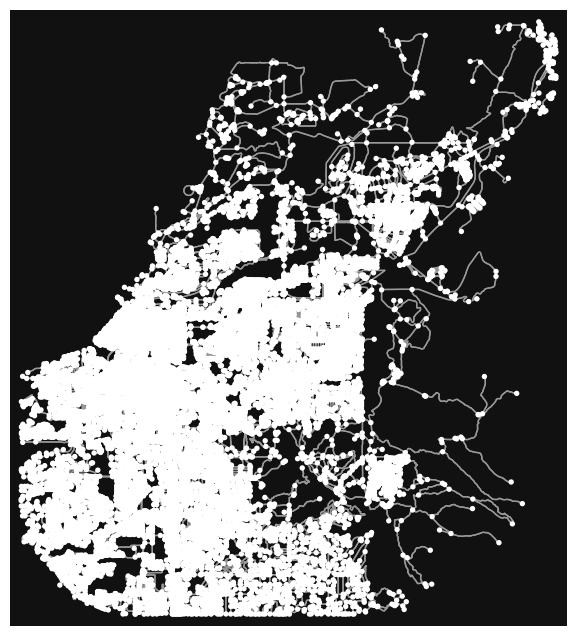

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph(G) #plotting it to see if it captured the network

In [126]:
# I am curious why the above is listed as walk but perhaps this is an osm thing? I can check here: 
nodes, edges = ox.graph_to_gdfs(G)

In [124]:
edges = edges[edges['highway'] == 'walk']

In [119]:
# Okay now I am going to do the directions to a random point and I am going to choose University of Alaska Anchorage 
uaa_point = (-149.81572, 61.19038)  # (lat, lon)
lat, lon = uaa_point

In [120]:
orig = ox.distance.nearest_nodes(G, lon, lat)
sample = anchorage_busstops.sample()    
dest = ox.distance.nearest_nodes(G, sample.geometry.x, sample.geometry.y)[0]

In [121]:
orig, dest

(889868408, np.int64(2039448876))

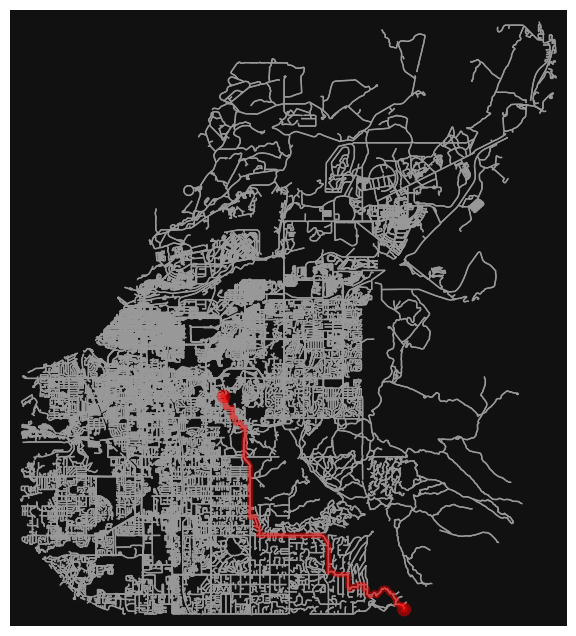

In [122]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [123]:
route

[889868408,
 2296261140,
 2296261180,
 889868427,
 889868750,
 889868695,
 889868675,
 887635136,
 887635033,
 65229683,
 65175197,
 65175195,
 65190411,
 65242566,
 65267344,
 65178007,
 65154392,
 65154394,
 65154398,
 65154401,
 65154427,
 65154440,
 65154522,
 8458796078,
 65236036,
 65236031,
 65236028,
 65224932,
 793881381,
 793897997,
 65255361,
 65272590,
 65221422,
 65270349,
 848933409,
 65239924,
 849018164,
 849018455,
 65206937,
 65272581,
 65211009,
 11998799328,
 848932700,
 65199853,
 848932754,
 65162262,
 65234169,
 65234201,
 65214839,
 65189866,
 65189861,
 65230740,
 65234185,
 65234183,
 65224407,
 65198564,
 65215830,
 65277712,
 8981495656,
 8981495653,
 65241096,
 65165353,
 65227701,
 65278523,
 65235606,
 65174419,
 65239010,
 8253275494,
 1878390117,
 2039441258,
 2611962261,
 10794202667,
 2611962262,
 2611962309,
 323184601,
 323184234,
 10936923507,
 323184708,
 323184667,
 323184231,
 323184093,
 323184103,
 10991480006,
 65202417,
 10211284016,
 102112

In [127]:
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

10.1588852630188